We are going to build an Autoencoder by training this model based on images that are noisy and images that are not noisy.

AutoEncoder is a type of NN to perform data encoding or what we called (representation learning)

if we have correlation between the data we could compress them and reduce the dimensionality. let's say that we have a excel sheet with 4 columns, and 2 of them are correlated, hence we could compress them into one column (by this we could reduce the dimensionality.)

For our problem (image noising) all the pixels that represent the images are independant, which mean that I can't compress them any more. that's an issue here (AE perfroms very poorly.)

In [1]:
pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 116kB/s 
     |████████████████████████████████| 3.8MB 40.2MB/s 
     |████████████████████████████████| 450kB 55.7MB/s 
     |████████████████████████████████| 81kB 13.4MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [0]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0'

In [0]:
import pandas as pd # used for data frame manipulation
import numpy as np # numerical analysis 
import matplotlib.pyplot as plt # visulaization and data plotting
import seaborn as sns # visulaization and data plotting
import random

Load the data 

In [5]:
from tensorflow.keras.datasets import mnist
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


DATA Visualization

In [6]:
X_train.shape
# we have 60K images each one is 28*28 pixel (gray scale images)

(60000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

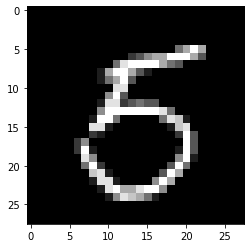

In [9]:
# Randomly select one image, then visualize this image and its label as well 
# choose the index of image out of 60K image of training data or 10K images of tested data
i = random.randint(1,60000)
plt.imshow(X_train[i],cmap='gray')

In [10]:
label = y_train[i]
label

5

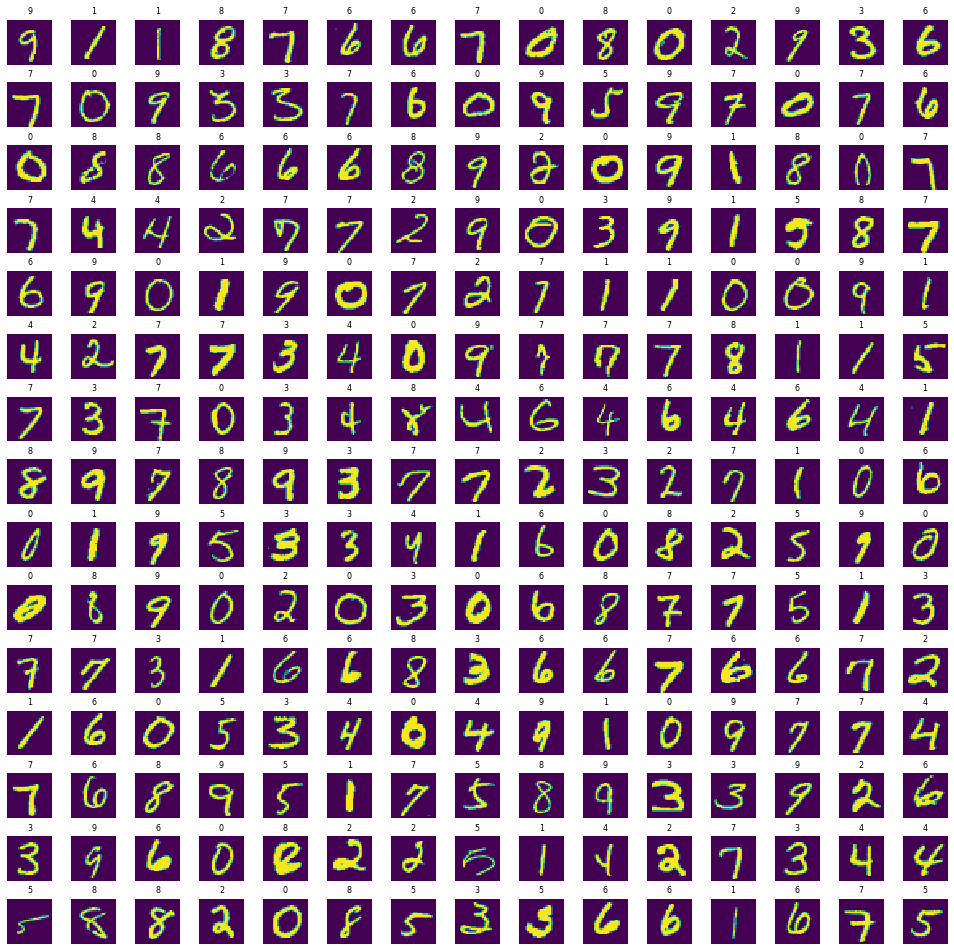

In [23]:
# to visualize the image and its label in one shot we need to use grid.
W_grid = 15
L_grid = 15
fig,axes = plt.subplots(L_grid,W_grid,figsize=(17,17))
axes = axes.ravel() # in order to flatten the 15 * 15 matrix to 225 array 
n_training = len(X_train)
for i in range (0, L_grid*W_grid):
  # we wanna get the index of images form the training set
  index = np.random.randint(0,n_training)
  axes[i].imshow( X_train[index] )
  axes[i].set_title(y_train[index], fontsize = 8)
  axes[i].axis('off')
# to make the title more clear so we should adjust the subplots
plt.subplots_adjust(hspace=0.4)

**Adding noise to our images**

In [0]:
# Image normalization by dividing by 255
X_train = X_train/255
X_test = X_test /255
# So the numbers of pixels are range between 0 and 1 instead of 0 and 255

In [0]:
# we will create some noise with same dimensions of the original data 
added_noise  = np.random.randn(*(28,28))# we created a random noise with size 28*28 and it will be the our added noise 

In [26]:
added_noise.shape

(28, 28)

The noise here is exactly like a kernel in Convolutional kernels 

In [0]:
# to define how aggressive we want the noise to be like, we need to define the noise factor 
noise_factor = 0.3
# update the added_noise or noise kernel according to noise_factor 
added_noise = noise_factor * np.random.randn(*(28,28))

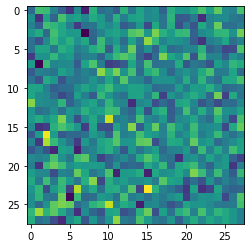

In [30]:
plt.imshow(added_noise)

In [0]:
# let's try to test this noise on the sample of images.
sample_image = X_train[10]
noise_sample_image = sample_image + added_noise

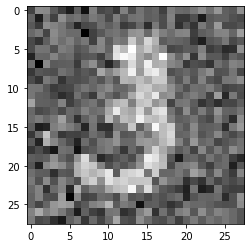

In [34]:
plt.imshow(noise_sample_image,cmap='gray')

Note that by adding noise, the normalization will be missed up 

In [35]:
noise_sample_image.min()

-0.9721998490411661

In [36]:
noise_sample_image.max()

1.5536278290722616

to fix this problem, we can clip our noisy image and make form 0 to 1

In [0]:
noise_sample_image = np.clip(noise_sample_image,0,1)

In [41]:
noise_sample_image.min()

0.0

In [42]:
noise_sample_image.max()

1.0

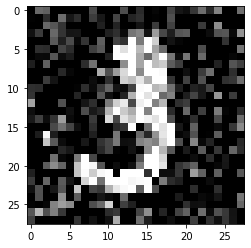

In [44]:
# if we have a look at the image it looks much more better
plt.imshow(noise_sample_image,cmap='gray')

Now we will add noise to the entire noising dataset

In [0]:
X_train_noise = []
for sample_image in X_train:
  sample_image_noise  = noise_sample_image + sample_image
  sample_image_noise = np.clip(sample_image_noise,0,1)
  X_train_noise.append(sample_image_noise)

In [0]:
# Now we have a list of noisy images. We will convert it into array 
X_train_noise = np.array(X_train_noise)

In [47]:
X_train_noise.shape

(60000, 28, 28)

Now we will add the same noisy to the tested images

In [48]:
X_test_noise = []
for sample_image in X_test:
  sample_image_noise = sample_image + noise_sample_image
  sample_image_noise = np.clip(sample_image_noise,0,1)
  X_test_noise.append(sample_image_noise)
X_test_noise = np.array(X_test_noise)
X_test_noise.shape

(10000, 28, 28)

All what we did in this step is preparing the data to be feeded into the auto encoder. We just add noise to the images by multiply the noise factor with random image 28*28 pixels 

**AUTOENCODER**

In [0]:
# define our model 
autoencoder = tf.keras.Sequential()
# Add layers to the encoder 
# The first layer will be convolutional layer with the following propoerties 
# 1. 16 kernels (filters), each one with 3*3 dimensions 
# 2. the kernels will stride or shift one pixel at a time upon images
# 3. the output dimention == to input dimension. 
# 4. because this is the first layer so I have to specify the dimension of input 
autoencoder.add(tf.keras.layers.Conv2D(16,(3,3),strides=1,padding='same',input_shape=(28,28,1)))
# Now we will add max pooling layer which will play the role of compressing the image
autoencoder.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'))
# add another convolutional layer and max pooling 
autoencoder.add(tf.keras.layers.Conv2D(8,(3,3),strides=1,padding='same'))
autoencoder.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'))
# here we will add a code layer. (this is where all the information is encoded )
autoencoder.add(tf.keras.layers.Conv2D(8,(3,3),strides=1,padding='same'))
# Now we will do the upsampling process by adding decoder CNN
# to do that we will use upsamling2D and Conv2DTranspose 
# it's a convolution in reverse so instead of maxpooling we gonna add an upsampling layer '
# rather than convolution we gonna add Conv2DTranspose
autoencoder.add(tf.keras.layers.UpSampling2D((2, 2)))
autoencoder.add(tf.keras.layers.Conv2DTranspose(8,(3,3),strides=1,padding='same'))
# add another Upsamling2D
autoencoder.add(tf.keras.layers.UpSampling2D((2, 2)))
# here is the output layer, so we will use the activation function to be sigmoid to keep the image normalized 
autoencoder.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=1,padding='same',activation='sigmoid'))
# the output of the autoencoder will be an image.

In [54]:
# Now to compile the model we will use the following property 
# loss function will be binary 
# optimizer will be adam 
# learning rate will be 1/1000 (how aggresiive I need my weight to be updated)
autoencoder.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 8)        

Firstly the size of last layer is exactly the one for the first layer. 
the size of the pooling in half of size of con2D

In [55]:
# The input of the autoencoder is actually the noisy data 
# The output of the autoencoder is the data without noise 
autoencoder.fit(X_train_noise.reshape(-1,28,28,1),X_train.reshape(-1,28,28,1),epochs=10,batch_size=200)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 41s 684us/sample - loss: 0.2164
Epoch 2/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.1267
Epoch 3/10
60000/60000 [==============================] - 40s 674us/sample - loss: 0.1159
Epoch 4/10
60000/60000 [==============================] - 41s 676us/sample - loss: 0.1105
Epoch 5/10
60000/60000 [==============================] - 41s 683us/sample - loss: 0.1071
Epoch 6/10
60000/60000 [==============================] - 41s 686us/sample - loss: 0.1050
Epoch 7/10
60000/60000 [==============================] - 41s 682us/sample - loss: 0.1033
Epoch 8/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.1021
Epoch 9/10
60000/60000 [==============================] - 40s 673us/sample - loss: 0.1010
Epoch 10/10
60000/60000 [==============================] - 40s 674us/sample - loss: 0.1001


**Evaluate the model **

In [0]:
denoise_image = autoencoder.predict(X_test_noise[:15].reshape(-1,28,28,1))

In [58]:
denoise_image.shape

(15, 28, 28, 1)

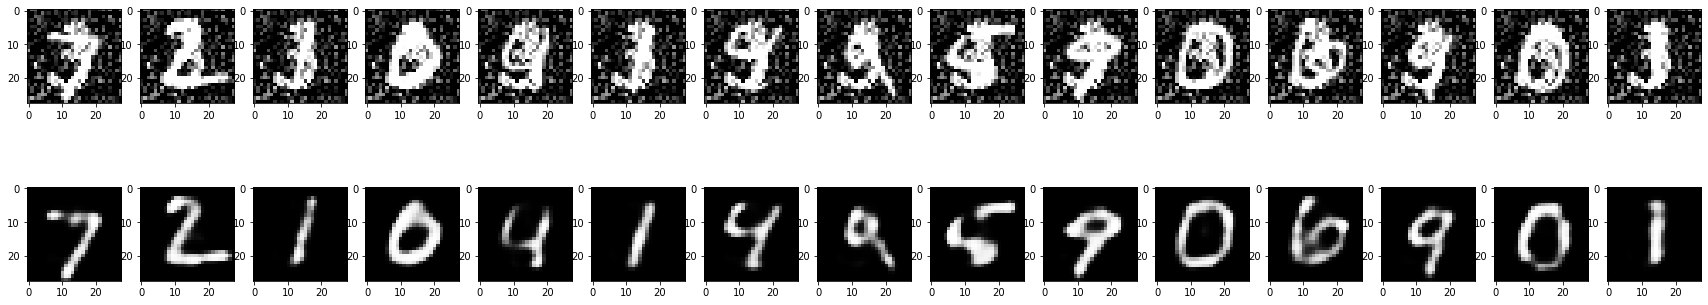

In [61]:
fig,axes = plt.subplots(nrows=2,ncols=15,figsize=(30,6))
for images, row in zip([X_test_noise[:15], denoise_image], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='gray')
